In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import h5py
from dataset.MatDataset import JHTDB_RECTANGULAR
from models.encoder import *

In [37]:
dataset = JHTDB_RECTANGULAR(root='data/jhtdb_transition_bl', tstart=1, tend=1000, fields='u', dataset='transition_bl', partition=True, sub_size=14)
full_sample = dataset.get_one_full_sample(100)

In [38]:
full_sample = full_sample[1]

In [39]:

sub_sample_0 = full_sample[370].squeeze()
sub_sample_1 = full_sample[1000].squeeze()
sub_sample_2 = full_sample[7250].squeeze()


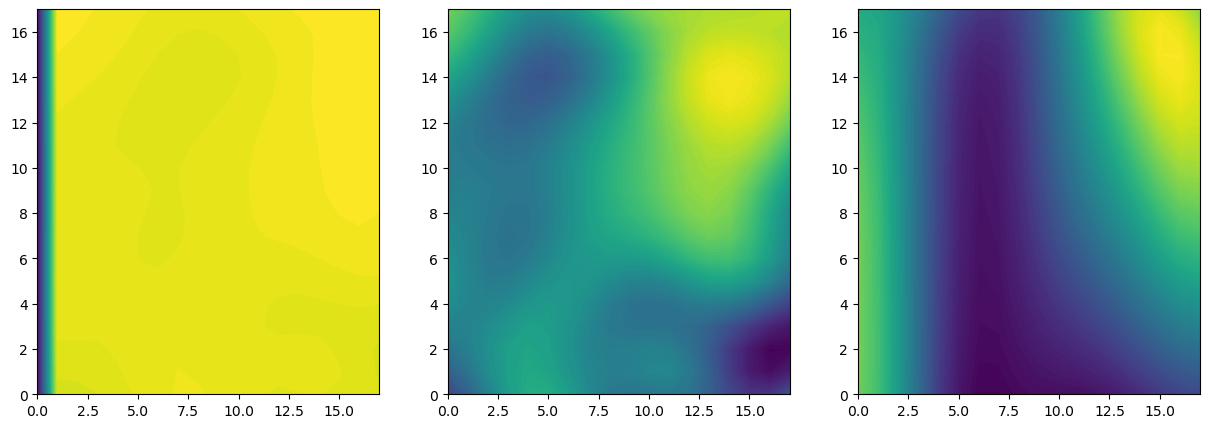

In [40]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].contourf(sub_sample_0, levels=100)
ax[1].contourf(sub_sample_1, levels=100)
ax[2].contourf(sub_sample_2, levels=100)

In [41]:
from models.encoder import SpectrumEncoder

encoder = SpectrumEncoder(n_components=10, domain_size=10)
tke_spectrum_0 = encoder._compute_tke_spectrum([sub_sample_0, 0.1963495, 0.1963495])
tke_spectrum_1 = encoder._compute_tke_spectrum([sub_sample_1, 0.1963495, 0.1963495])
tke_spectrum_2 = encoder._compute_tke_spectrum([sub_sample_2, 0.1963495, 0.1963495])

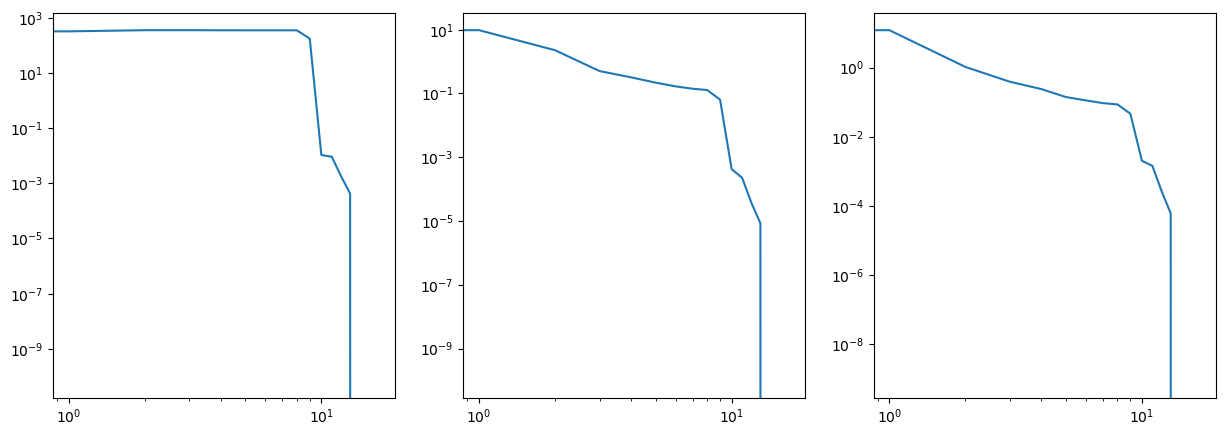

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].loglog(tke_spectrum_0)
ax[1].loglog(tke_spectrum_1)
ax[2].loglog(tke_spectrum_2)